# Compute the Garud H statistics for the West african populations

In [ ]:
#!pip install malariagen_data
#!pip install scikit-allel
#!pip install petl

In [2]:
import malariagen_data
import allel
import numpy as np
import pandas as pd
import functools
from dask.diagnostics.progress import ProgressBar
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [3]:
#Mounting Google Drive
#import os
#from google.colab import drive
#drive.mount("drive")

# make dir 
#results_dir = "drive/MyDrive/Fru_paper"
#os.makedirs(results_dir, exist_ok=True)

Mounted at drive


In [4]:
ag3 = malariagen_data.Ag3()
#ag3

In [5]:
## Selecting and defining the samples metadata
sets = ['AG1000G-BF-A', 'AG1000G-BF-B', 'AG1000G-BF-C', 'AG1000G-CI', 'AG1000G-GH', 'AG1000G-GM-A', 'AG1000G-GM-B', 
        'AG1000G-GM-C', 'AG1000G-GN-A', 'AG1000G-GW',  'AG1000G-ML-A', 'AG1000G-ML-B']
df_samples = ag3.sample_metadata(sample_sets=sets)

## Acces to the haplotypes 
df_hap = ag3.haplotypes(region="X", analysis='gamb_colu_arab', sample_sets=sets)

#df_samples.groupby(['country', 'aim_species']).size()

Load sample metadata:   0%|          | 0/12 [00:00<?, ?it/s]

In [6]:
## SNP haplotypes positions 
pos = allel.SortedIndex(df_hap["variant_position"].values)
#loc_region = pos.locate_range(0,20000000)
#pos_loc = pos[loc_region]
#sel_haps = df_hap.sel(variants = loc_region)
#gt = allel.GenotypeDaskArray(sel_haps['call_genotype'].data)
gt = allel.GenotypeDaskArray(df_hap['call_genotype'].data)

In [7]:
# Select sample with size >= 30
samples_phased = df_hap['sample_id'].values
df_samples_phased = df_samples.set_index("sample_id").loc[samples_phased].reset_index()

pop_cohort = dict([(f"{c} (An. {s})", list(df.index)) for (c, s), df in df_samples_phased.groupby(['country_iso', 'aim_species'])])
#sp_cohort = dict([(f"An. {s}", list(df.index)) for (s), df in df_samples_phased.groupby(['aim_species'])])

sample_id, sel_pop = [], []
for key in pop_cohort.keys():
    if len(pop_cohort[key])>=30 and key.split('. ')[1][:3] != 'int':
        for i in pop_cohort[key]:
            sample_id.append(i)
        sel_pop.append(key)

In [8]:
## Compute genotypes 
gt_cohort = {}
for key in sel_pop:
  gt_cohort[key] = gt.take(pop_cohort[key], axis=1) 

In [9]:
## Compute haplotypes 
ht_cohort = {}
with ProgressBar():
  for key in sel_pop:
    ht_cohort[key] = gt_cohort[key].to_haplotypes().compute()

[########################################] | 100% Completed | 33.1s
[########################################] | 100% Completed | 31.2s
[########################################] | 100% Completed | 18.0s
[########################################] | 100% Completed | 13.4s
[########################################] | 100% Completed |  6.5s
[########################################] | 100% Completed |  8.3s
[########################################] | 100% Completed | 39.8s
[########################################] | 100% Completed | 14.1s
[########################################] | 100% Completed | 14.8s
[########################################] | 100% Completed | 14.8s


In [10]:
## Compute garud statistics 
H1, H12, H123, H1_2 = {}, {}, {}, {}
window_pos = allel.moving_statistic(pos, statistic=np.mean, size=2000)
for key in ht_cohort.keys():
  H1[key], H12[key], H123[key], H1_2[key] = allel.moving_garud_h(ht_cohort[key], size=2000)

In [18]:
## Warp
frame1, frame2, frame3, frame4, country_id = [], [], [], [], []
for key in ht_cohort.keys():
  for n in range(len(H1[key])):
    frame1.append(H1[key][n])
    frame2.append(H12[key][n])
    frame3.append(H123[key][n])
    frame4.append(H1_2[key][n])
    country_id.append(key)

garud_stat = pd.DataFrame(list(zip(list(window_pos)*10, country_id, frame1, frame2, frame3, frame4)), 
                          columns =['pos', 'pops', 'H1', 'H12', 'H123', 'H1_2'])
#garud_stat.to_csv('drive/MyDrive/Fru_paper/Fru_analysis_tabs/garud_stat_west.csv')

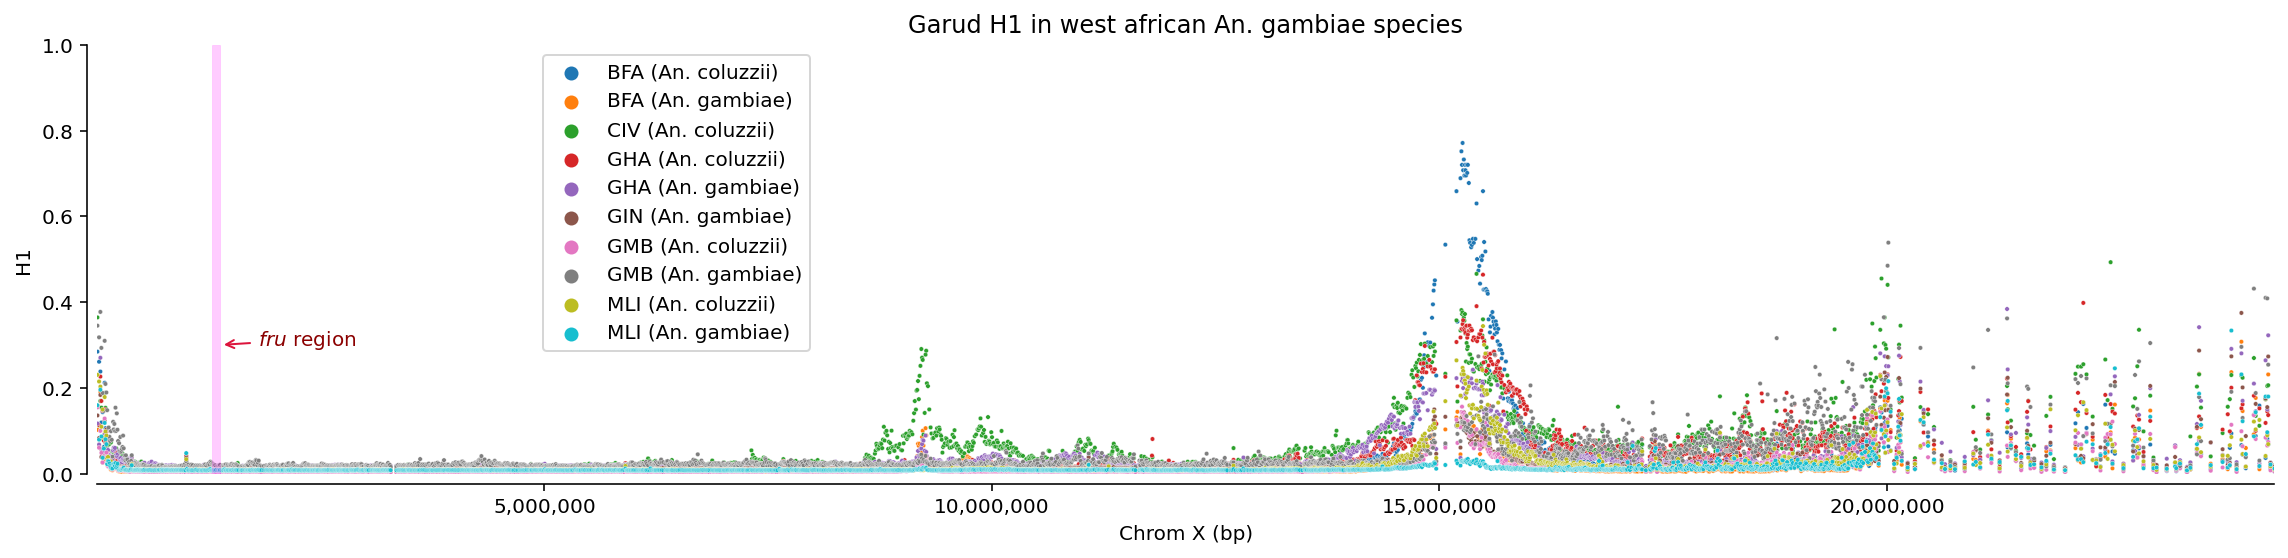

In [12]:
xlim1 = window_pos
fig, ax = plt.subplots(figsize=(16, 4))
sns.despine(ax=ax, offset=5)

ax = sns.scatterplot(x='pos', y='H1', hue='pops', data=garud_stat, s=5)
ax.legend(loc='best', bbox_to_anchor=(0.2, 0.5, 0.5, 0.5))
ax.set(title = 'Garud H1 in west african An. gambiae species', xlabel = 'Chrom X (bp)')
ax.axvspan(1283016, 1373662, color='magenta', alpha=0.2, lw=0.3)
#ax.axvline(x=1283016, ymax=0.8, color='gray', linestyle='-', linewidth=0.5)
#ax.axvline(x=1309218,  color='gray', linestyle='-', linewidth=0.5)
#ax.axvline(x=1300290,  color='blue', linestyle='-', linewidth=0.5)
#ax.axvline(x=1373662, ymax=0.5,  color='gray', linestyle='-', linewidth=0.5)
ax.annotate('$fru$ region', xy=(1373662, 0.3), xytext=(1800000, 0.3), color='darkred',
            arrowprops=dict(arrowstyle="->", color='crimson'))

#ax setting 
ax.set_ylim(0,1)
xlim=[xlim1[0], xlim1[-1]]
ax.set_xlim(*xlim)
ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])

fig.tight_layout()
#fig.savefig(f"drive/MyDrive/Fru_paper/Fru_graph/West_Garud_H1.png", dpi=300, bbox_inches='tight')

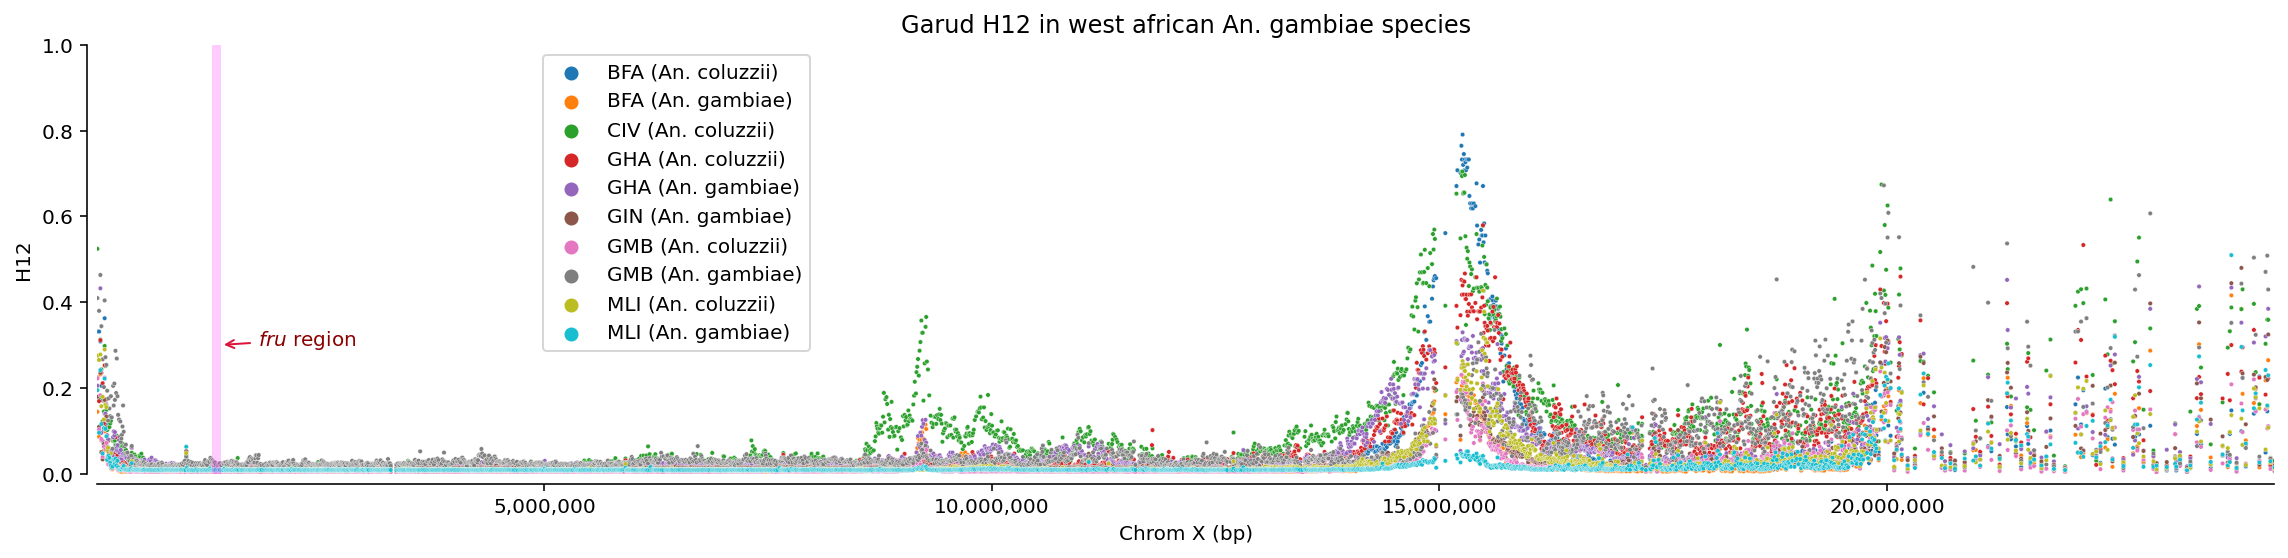

In [13]:
xlim1 = window_pos
fig, ax = plt.subplots(figsize=(16, 4))
sns.despine(ax=ax, offset=5)

ax = sns.scatterplot(x='pos', y='H12', hue='pops', data=garud_stat, s=5)
ax.legend(loc='best', bbox_to_anchor=(0.2, 0.5, 0.5, 0.5))
ax.set(title = 'Garud H12 in west african An. gambiae species', xlabel = 'Chrom X (bp)')
ax.axvspan(1283016, 1373662, color='magenta', alpha=0.2, lw=0.3)
#ax.axvline(x=1283016, ymax=0.8, color='gray', linestyle='-', linewidth=0.5)
#ax.axvline(x=1309218,  color='gray', linestyle='-', linewidth=0.5)
#ax.axvline(x=1300290,  color='blue', linestyle='-', linewidth=0.5)
#ax.axvline(x=1373662, ymax=0.5,  color='gray', linestyle='-', linewidth=0.5)
ax.annotate('$fru$ region', xy=(1373662, 0.3), xytext=(1800000, 0.3), color='darkred',
            arrowprops=dict(arrowstyle="->", color='crimson'))

#ax setting 
ax.set_ylim(0,1)
xlim=[xlim1[0], xlim1[-1]]
ax.set_xlim(*xlim)
ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])

fig.tight_layout()
#fig.savefig(f"drive/MyDrive/Fru_paper/Fru_graph/West_Garud_H12.png", dpi=300, bbox_inches='tight')

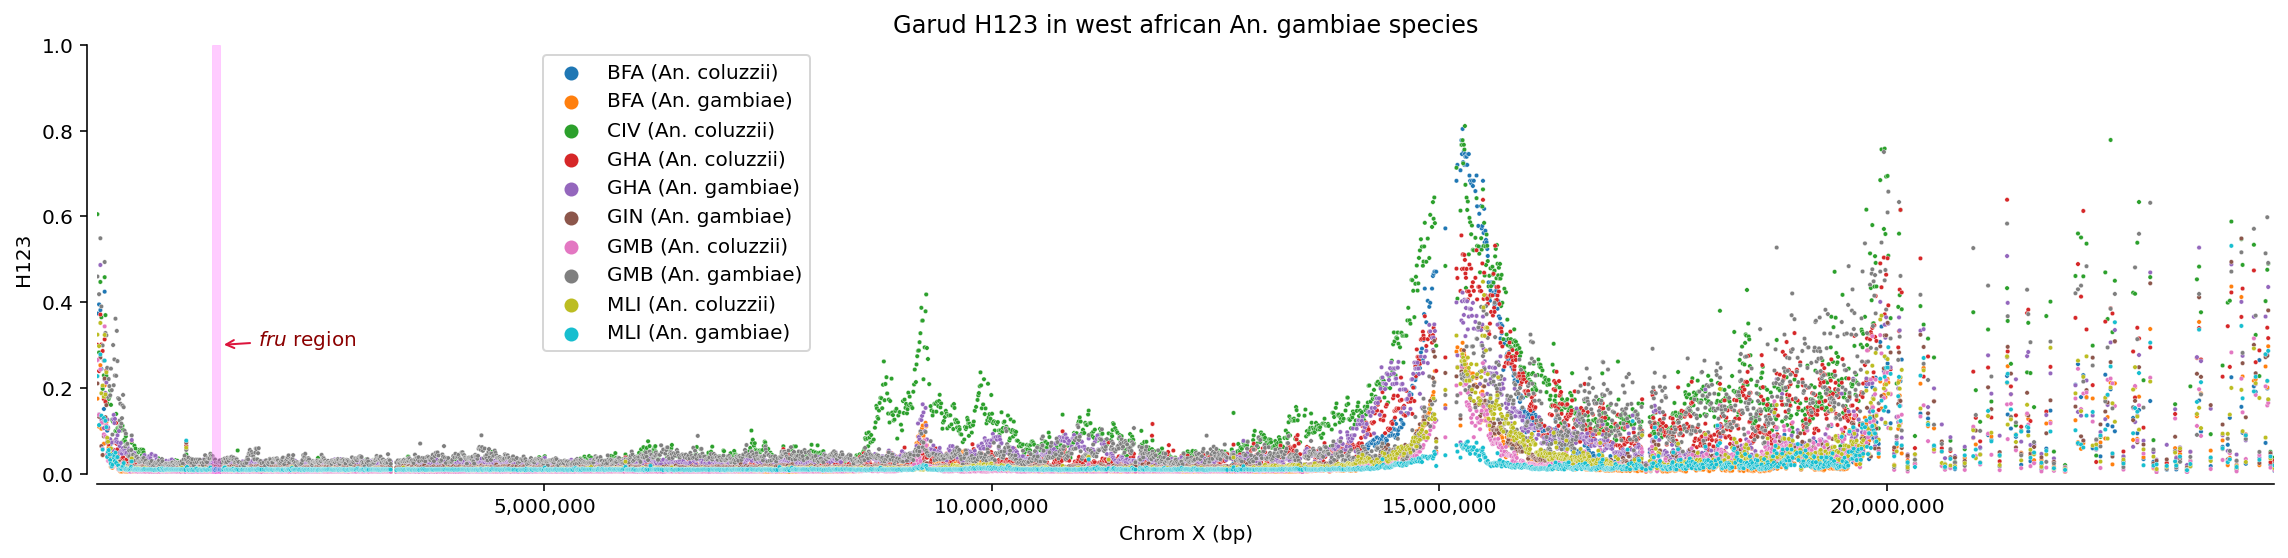

In [14]:
xlim1 = window_pos
fig, ax = plt.subplots(figsize=(16, 4))
sns.despine(ax=ax, offset=5)

ax = sns.scatterplot(x='pos', y='H123', hue='pops', data=garud_stat, s=5)
ax.legend(loc='best', bbox_to_anchor=(0.2, 0.5, 0.5, 0.5))
ax.set(title = 'Garud H123 in west african An. gambiae species', xlabel = 'Chrom X (bp)')
ax.axvspan(1283016, 1373662, color='magenta', alpha=0.2, lw=0.3)
#ax.axvline(x=1283016, ymax=0.8, color='gray', linestyle='-', linewidth=0.5)
#ax.axvline(x=1309218,  color='gray', linestyle='-', linewidth=0.5)
#ax.axvline(x=1300290,  color='blue', linestyle='-', linewidth=0.5)
#ax.axvline(x=1373662, ymax=0.5,  color='gray', linestyle='-', linewidth=0.5)
ax.annotate('$fru$ region', xy=(1373662, 0.3), xytext=(1800000, 0.3), color='darkred',
            arrowprops=dict(arrowstyle="->", color='crimson'))

#ax setting 
ax.set_ylim(0,1)
xlim=[xlim1[0], xlim1[-1]]
ax.set_xlim(*xlim)
ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])

fig.tight_layout()
#fig.savefig(f"drive/MyDrive/Fru_paper/Fru_graph/West_Garud_H123.png", dpi=300, bbox_inches='tight')

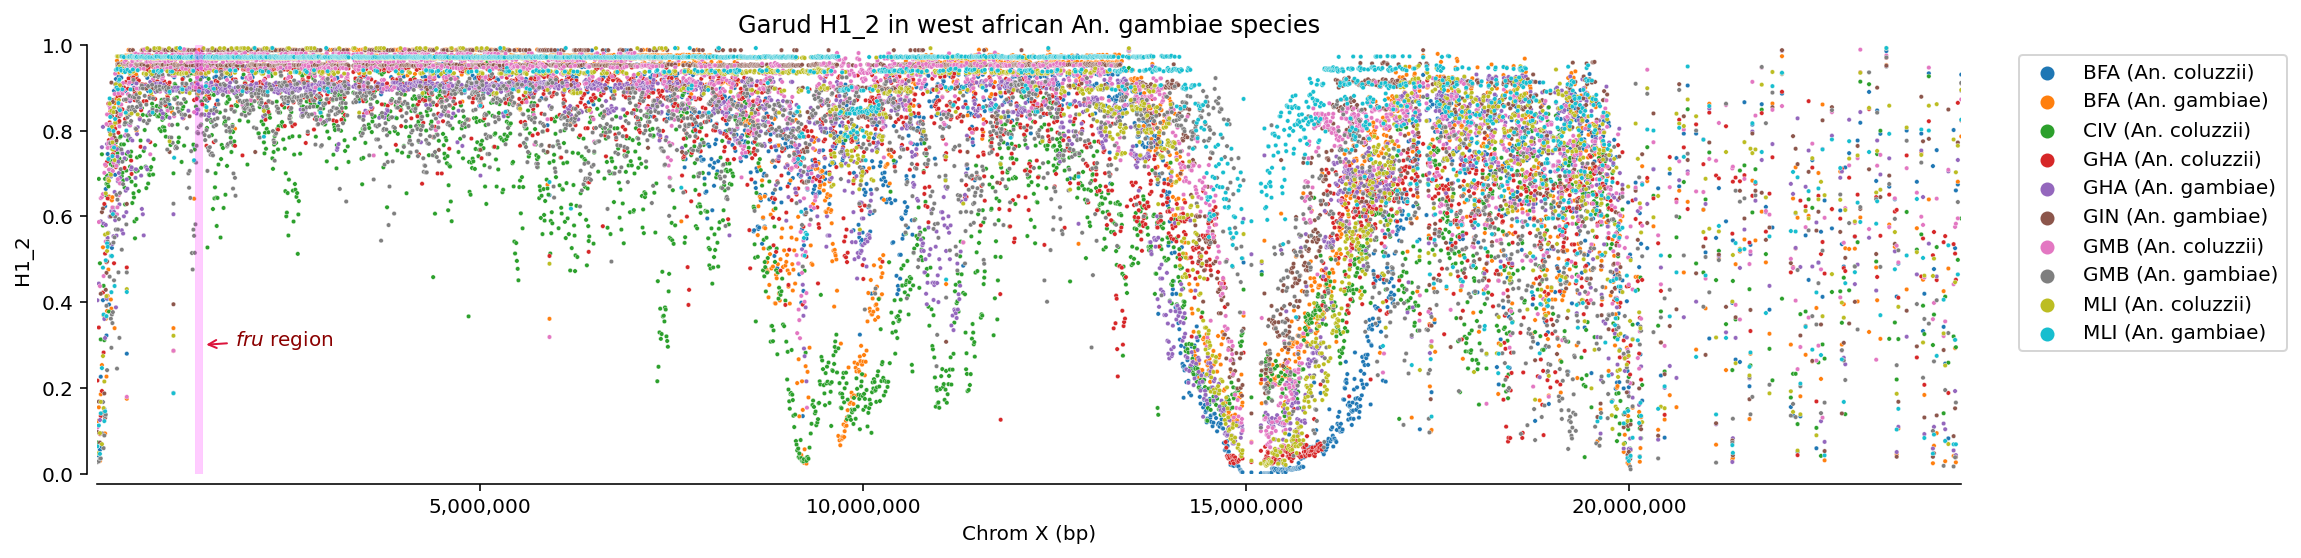

In [15]:
xlim1 = window_pos
fig, ax = plt.subplots(figsize=(16, 4))
sns.despine(ax=ax, offset=5)

ax = sns.scatterplot(x='pos', y='H1_2', hue='pops', data=garud_stat, s=5)
ax.legend(loc='best', bbox_to_anchor=(0.68, 0.5, 0.5, 0.5))
ax.set(title = 'Garud H1_2 in west african An. gambiae species', xlabel = 'Chrom X (bp)')
ax.axvspan(1283016, 1373662, color='magenta', alpha=0.2, lw=0.3)
#ax.axvline(x=1283016, ymax=0.8, color='gray', linestyle='-', linewidth=0.5)
#ax.axvline(x=1309218,  color='gray', linestyle='-', linewidth=0.5)
#ax.axvline(x=1300290,  color='blue', linestyle='-', linewidth=0.5)
#ax.axvline(x=1373662, ymax=0.5,  color='gray', linestyle='-', linewidth=0.5)
ax.annotate('$fru$ region', xy=(1373662, 0.3), xytext=(1800000, 0.3), color='darkred',
            arrowprops=dict(arrowstyle="->", color='crimson'))

#ax setting 
ax.set_ylim(0,1)
xlim=[xlim1[0], xlim1[-1]]
ax.set_xlim(*xlim)
ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])

fig.tight_layout()
#fig.savefig(f"drive/MyDrive/Fru_paper/Fru_graph/West_Garud_H1_2.png", dpi=300, bbox_inches='tight')

In [16]:
# garud H statistics 
garud_fru = garud_stat.query('pos>1283016 and pos<1373662')
garud_fru.describe()

,pos,H1,H12,H123,H1_2
count,1.000000e+02,100.000000,100.000000,100.000000,100.000000
mean,1.321950e+06,0.009996,0.011475,0.013617,0.917855
std,2.724987e+04,0.005391,0.006896,0.009126,0.065433
min,1.284113e+06,0.003327,0.003408,0.003570,0.581395
25%,1.299577e+06,0.004486,0.004847,0.005487,0.891745
50%,1.316350e+06,0.008629,0.009430,0.010645,0.943394
75%,1.348399e+06,0.013438,0.014766,0.017383,0.968987
max,1.367888e+06,0.022928,0.030486,0.040564,0.987952


In [17]:
garud_fru.query('H12 > 0.02')

,pos,pops,H1,H12,H123,H1_2
4804,1.299577e+06,CIV (An. coluzzii),0.016172,0.021172,0.028672,0.845411
9460,1.299577e+06,GHA (An. gambiae),0.019290,0.023920,0.029321,0.840000
9461,1.306070e+06,GHA (An. gambiae),0.020448,0.025077,0.033179,0.849057
9462,1.312853e+06,GHA (An. gambiae),0.018904,0.022377,0.029321,0.908163
9467,1.367888e+06,GHA (An. gambiae),0.017747,0.020062,0.023920,0.902174
16442,1.284113e+06,GMB (An. gambiae),0.021668,0.027715,0.035777,0.581395
16443,1.292181e+06,GMB (An. gambiae),0.022928,0.030486,0.040564,0.725275
16444,1.299577e+06,GMB (An. gambiae),0.021668,0.027337,0.036155,0.764535
16445,1.306070e+06,GMB (An. gambiae),0.019652,0.026707,0.034266,0.794872
16446,1.312853e+06,GMB (An. gambiae),0.019778,0.024817,0.033006,0.796178
